# Exploration Notebook - Jacopo
**Version**: v0

**Goal**: explore the data, understand the problem, and get a first naive working model

**Folder Structure**: 
- `data/` - all data 
- `data/twitter-datasets/` - provided data
- `data/out/` - output data, predictions
- `project_text_classification/` - provided code + embeddings obtained with GloVe implementation provided

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [40]:
# Load data, txt as csv
data_path = 'data/twitter-datasets/'
df_train_pos = pd.read_csv(data_path + 'train_pos.txt', sep = '\t', names = ['tweet'])
df_train_pos['label'] = 1
df_train_neg = pd.read_csv(data_path + 'train_neg.txt', sep = '\t', names = ['tweet'])
df_train_neg['label'] = 0
df_train = pd.concat([df_train_pos, df_train_neg])
print('Train set: ', df_train.shape)
print('Train set positives: ', df_train_pos.shape)
print('Train set negatives: ', df_train_neg.shape)

Train set:  (196970, 2)
Train set positives:  (97902, 2)
Train set negatives:  (99068, 2)


In [3]:
df_train_pos.head()

,tweet,label
0,<user> i dunno justin read my mention or not ....,1
1,"because your logic is so dumb , i won't even c...",1
2,<user> just put casper in a box ! looved the...,1
3,<user> <user> thanks sir > > don't trip lil ma...,1
4,visiting my brother tmr is the bestest birthda...,1


In [4]:
df_train_neg.head()

,tweet,label
0,vinco tresorpack 6 ( difficulty 10 of 10 objec...,0
1,glad i dot have taks tomorrow ! ! #thankful #s...,0
2,1-3 vs celtics in the regular season = were fu...,0
3,<user> i could actually kill that girl i'm so ...,0
4,<user> <user> <user> i find that very hard to ...,0


## Load Embeddings and Vocabulary computed with GloVe
**v0-preprocessing**:
- Vocabulary from the training set only
- Only words that appear at least 5 times (`grep -v "^[1234]\s"` in cut_vocab.sh)
- D = 20 for the embeddings


In [5]:
# Load embeddings and vocab computed in glove_solution.py, cooc.py, build_vocab.sh, cut_vocab.sh
embeddings = np.load('project_text_classification/embeddings.npy')
print('Embeddings shape: ', embeddings.shape)

Embeddings shape:  (101298, 20)


In [6]:
# Load vocab
with open('project_text_classification/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
print('Vocab size: ', len(vocab))
print('First 10 words with first 5 embeddings out of 20: ')
for i, (k, v) in enumerate(vocab.items()):
    if i < 10:
        print(v,'   ', k, '   ', embeddings[v][:5])



Vocab size:  101298
First 10 words with first 5 embeddings out of 20: 
0     <user>     [-0.03479712 -0.07365628 -0.00743188 -0.00788228  0.02426597]
1     !     [-0.0836218  -0.17009606  0.01400596 -0.04496939  0.06164988]
2     i     [-0.09792921 -0.20330115 -0.00564132 -0.05139399  0.05120932]
3     the     [-0.03055286 -0.06086687 -0.01190551 -0.00499993  0.05682487]
4     .     [-0.04091219 -0.09596251  0.01774639 -0.01060146  0.03199516]
5     ,     [-0.01024456 -0.05366561  0.00076152 -0.00700359  0.04335792]
6     to     [-0.09594229 -0.18170194  0.00853042 -0.03531667  0.0620693 ]
7     you     [-0.17485842 -0.39461575 -0.02115954 -0.08810722  0.10670072]
8     (     [-0.01947013 -0.01521287 -0.0057669   0.01370244  0.01793526]
9     <url>     [-0.01884383 -0.03261202  0.00045006  0.00241035  0.01886935]


## Construct Features
**v0-features**:
- Average of all embeddings of the words in the tweet

In [7]:
# Construct Feature Matrix function
def build_feature_matrix_v0(df, vocab, embeddings, mode='avg'):
    """
    Input:
        df: pandas DataFrame with column 'tweet', where each row is a tweet (N rows)
        vocab: dictionary mapping words to indices (the loaded vocab from vocab.pkl, length V is 101298 in v0 with GloVe embeddings with cooc matrix counting only words with at least 5 occurrences)
        embeddings: numpy array of shape (V, D) where V is the size of the vocabulary and D is the dimensionality of the word embeddings (in v0 with GloVe embeddings, D = 20)
    Output:
        X: numpy array of shape (N, D) where N is the number of tweets in df and D is the dimensionality of the word embeddings
    """
    X = np.zeros((df.shape[0], embeddings.shape[1]))
    for i, tweet in enumerate(df['tweet']):
        words = tweet.split()
        for word in words:
            if word in vocab:
                X[i] += embeddings[vocab[word]]
        if mode == 'avg':
            X[i] /= len(words)

    return X


In [8]:
# Construct Feature Matrix
X_train_full = build_feature_matrix_v0(df_train, vocab, embeddings, mode='avg')
print('Feature matrix shape: ', X_train_full.shape)
print('First 2 rows of feature matrix: ', X_train_full[:2])

Feature matrix shape:  (196970, 20)
First 2 rows of feature matrix:  [[-2.12743647e-01 -4.66915704e-01  1.79795781e-03 -7.90512461e-02
   9.82451000e-02  3.56712983e-01 -1.18187026e-01  1.51243751e-02
  -4.02296686e-01  4.69095194e-01  5.83330371e-02  4.28107825e-01
   2.28117727e-01 -2.92956517e-04 -4.13620524e-01 -4.04385531e-02
   1.93489122e-01  3.78506652e-01  1.51826272e-01  4.02271820e-01]
 [-3.64756550e-02 -3.58745609e-01 -8.52176162e-02  5.82765480e-02
  -4.69203802e-03  3.61547823e-01 -8.21367314e-02  1.72882134e-01
  -3.35769769e-01  4.36906602e-01  7.22405427e-02  3.82444782e-01
   1.20414009e-01  1.25260226e-01 -3.76953598e-01 -1.92834464e-01
   3.75952487e-01  2.56937385e-01  1.10645393e-01  3.26992915e-01]]


In [9]:
# Construct labels vector
y_train_full = df_train['label'].values
print('Labels vector shape: ', y_train_full.shape)

Labels vector shape:  (196970,)


## Train Linear Classifier

In [10]:
# sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [11]:
# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
print('Train set shape: ', X_train.shape)
print('Validation set shape: ', X_val.shape)

Train set shape:  (157576, 20)
Validation set shape:  (39394, 20)


In [12]:
# Train Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.5730568106818297

## Test, Prediction, Evaluation

In [13]:
# Helper Function
def print_stats(y_val, y_pred):
    print('Accuracy: ', accuracy_score(y_val, y_pred))
    print('Precision: ', precision_score(y_val, y_pred))
    print('Recall: ', recall_score(y_val, y_pred))
    print('F1: ', f1_score(y_val, y_pred))
    print('Confusion matrix: ')
    print(confusion_matrix(y_val, y_pred))

In [14]:
# Predict on validation set
y_pred = clf.predict(X_val)
# print stats
print_stats(y_val, y_pred)


Accuracy:  0.5730568106818297
Precision:  0.5637840866641763
Recall:  0.617564318960667
F1:  0.5894500451582981
Confusion matrix: 
[[10501  9342]
 [ 7477 12074]]


# Train with Cross Validation

In [15]:
# Cross Validation naive
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train_full, y_train_full, cv=5)
print('Cross validation scores: ', scores)
print('Cross validation mean score: ', np.mean(scores))

Cross validation scores:  [0.58798294 0.56810682 0.57112758 0.56518759 0.56242067]
Cross validation mean score:  0.5709651215921208


In [16]:
# K-Fold Cross Validation + shuffle
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42) # 42 is the answer to everything
scores = []
ws = []
for train_index, val_index in kf.split(X_train_full):
    X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
    y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]
    clf.fit(X_train_fold, y_train_fold)
    scores.append(clf.score(X_val_fold, y_val_fold))
    ws.append(clf.coef_)
print('K-Fold cross validation scores: ', scores)
print('K-Fold cross validation mean score: ', np.mean(scores))
# final weights
w = np.mean(ws, axis=0)
clf.coef_ = w

K-Fold cross validation scores:  [0.5730568106818297, 0.5724729654262071, 0.5714829669492816, 0.5709752754226533, 0.5746306544143778]
K-Fold cross validation mean score:  0.5725237345788698


Area under the curve:  0.6045149722235306


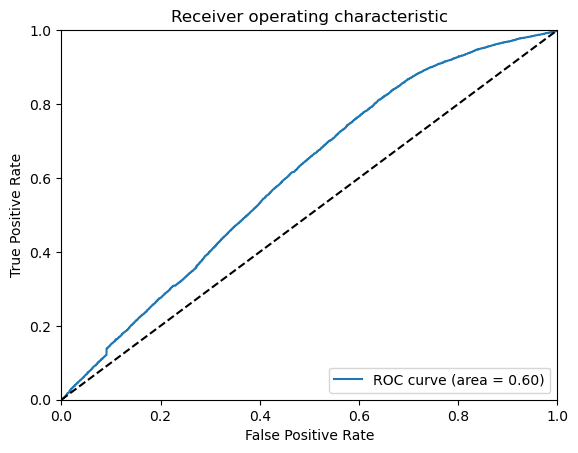

In [17]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# Predict probabilities on 1s
y_pred_prob = clf.predict_proba(X_val)[:, 1]
# Compute false positive rate, true positive rate and thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
# Compute area under the curve
roc_auc = auc(fpr, tpr)
print('Area under the curve: ', roc_auc)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Prediction on Test set and Evaluation of Submission

In [18]:
# Load test data: id, tweet for each row
data_path = 'data/twitter-datasets/'
df_test = pd.read_csv(data_path + 'test_data.txt', header=None, names=['line'], sep='\t')
# Extract id and tweet, limit split by 1 so we don't split the tweet (this is v0, at least we keep it intact)
df_test['id'] = df_test['line'].apply(lambda x: x.split(',',1)[0]) 
df_test['tweet'] = df_test['line'].apply(lambda x: x.split(',',1)[1])
df_test = df_test.drop('line', axis=1)
print('Test set shape: ', df_test.shape)
print(df_test.head(5))

Test set shape:  (10000, 2)
  id                                              tweet
0  1  sea doo pro sea scooter ( sports with the port...
1  2  <user> shucks well i work all week so now i ca...
2  3            i cant stay away from bug thats my baby
3  4  <user> no ma'am ! ! ! lol im perfectly fine an...
4  5  whenever i fall asleep watching the tv , i alw...


In [19]:
# Construct Feature Matrix
X_test = build_feature_matrix_v0(df_test, vocab, embeddings, mode='avg')
print('Feature matrix shape: ', X_test.shape)
print('First 2 rows of feature matrix: ', X_test[:2])

Feature matrix shape:  (10000, 20)
First 2 rows of feature matrix:  [[-0.15821538 -0.21607353  0.12250205  0.16856103  0.07314589  0.27110023
  -0.29175464  0.07790856  0.00564304  0.2801317   0.12207355  0.16808213
   0.16112774  0.0159998  -0.20395927 -0.18216626 -0.04774695  0.10113141
  -0.05613875  0.33276342]
 [-0.18726689 -0.50515776  0.10674097  0.05197665  0.06420699  0.25739773
  -0.00205906 -0.09593857 -0.38205694  0.43819085  0.23180705  0.27712226
   0.28818373  0.19578222 -0.31208164 -0.10316656  0.07110251  0.30208367
  -0.01240639  0.35135076]]


In [20]:
# Predict on test set, cast values, save to csv
y_pred = clf.predict(X_test)
df_test['Prediction'] = y_pred
df_test = df_test.rename(columns={'id': 'Id'})
df_test['Prediction'] = df_test['Prediction'].apply(lambda x: -1 if x == 0 else x)
data_path = 'data/out/'
df_test.to_csv(data_path + 'submission-v0.csv', columns=['Id', 'Prediction'], index=False)

## Evaluation of v0-0

**ACCURACY** : 0.583
**F1 SCORE** : 0.606

## Quick Iterations: v0-1 to v0-7
- **v0.1**: SVM
- **v0.2**: Naive Bayes (Generative Model)
- **v0.3**: Logistic Regression with preprocessing (lowercase, ~~remove punctuation~~, (remove stopwords), stemming)
- **v0.4**: Logistic Regression (or winner of above) with preprocessing and n-grams
- **v0.5**: Logistic Regression with preprocessing and n-grams and TF-IDF
- **v0.6**: Logistic Regression with preprocessing and n-grams and TF-IDF and L2 regularization
- **v0.7**: Logistic Regression with preprocessing and n-grams and TF-IDF and L2 regularization and 1000 features

In [21]:
# Quick Iterations, all with k-fold, shuffle and random without fixed state
#kf = KFold(n_splits=5, shuffle=True)
# v0.1: SVM
# from sklearn.svm import SVC
# clf = SVC(kernel='linear')
# scores = cross_val_score(clf, X_train_full, y_train_full, cv=kf)
# print('Cross validation scores: ', scores)
# print('Cross validation mean score: ', np.mean(scores))

# v0.2: Naive Bayes
#from sklearn.naive_bayes import GaussianNB
#clf = GaussianNB()
#scores = cross_val_score(clf, X_train_full, y_train_full, cv=kf)
#print('Cross validation scores: ', scores)
#print('Cross validation mean score: ', np.mean(scores))

# v0.3: Random Forest
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier()
# scores = cross_val_score(clf, X_train_full, y_train_full, cv=kf)
# print('Cross validation scores: ', scores)
# print('Cross validation mean score: ', np.mean(scores))
# v0.4: Gradient Boosting
# from sklearn.ensemble import GradientBoostingClassifier
# clf = GradientBoostingClassifier()
# #scores = cross_val_score(clf, X_train_full, y_train_full, cv=kf)
# print('Cross validation scores: ', scores)
# print('Cross validation mean score: ', np.mean(scores))
# v0.5: Logistic Regression
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression()
#scores = cross_val_score(clf, X_train_full, y_train_full, cv=kf)
#print('Cross validation scores: ', scores)
#print('Cross validation mean score: ', np.mean(scores))
# v0.6: KNN
#from sklearn.neighbors import KNeighborsClassifier
#clf = KNeighborsClassifier()
#scores = cross_val_score(clf, X_train_full, y_train_full, cv=kf)
#print('Cross validation scores: ', scores)
#print('Cross validation mean score: ', np.mean(scores))
# v0.7: Decision Tree
#from sklearn.tree import DecisionTreeClassifier
#clf = DecisionTreeClassifier()
#scores = cross_val_score(clf, X_train_full, y_train_full, cv=kf)
#print('Cross validation scores: ', scores)
#print('Cross validation mean score: ', np.mean(scores))

# Bayes
# Cross validation scores:  [0.58336295 0.58318526 0.57795603 0.58414987 0.57754988]
# Cross validation mean score:  0.5812407980910799
# Random Forest
# Cross validation scores:  [0.56975682 0.57704219 0.57468142 0.57069605 0.56863989]
# Cross validation mean score:  0.5721632735949637
# Logistic Regression
# Cross validation scores:  [0.56975682 0.57704219 0.57468142 0.57069605 0.56863989]
# Cross validation mean score:  0.5721632735949637
# Decision Tree -- good actually
# Cross validation scores:  [0.59080063 0.59356755 0.58709448 0.58912525 0.59224755]
# Cross validation mean score:  0.590567091435244
# Cross validation scores:  [0.59328832 0.58948063 0.59295832 0.59689293 0.59509062]
# Cross validation mean score:  0.5935421637812865


In [22]:
# predict with decision tree
# split into train and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2)

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, y_pred))
print('F1 score: ', f1_score(y_val, y_pred))

Accuracy:  0.5945829314108747
F1 score:  0.589761372685007


In [23]:
# predict with random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, y_pred))
print('F1 score: ', f1_score(y_val, y_pred))

Accuracy:  0.5905467837741788
F1 score:  0.6242020409114207


In [24]:
# a bit of hyperparameter tuning for random forest that seems to work
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 8],
    'n_estimators': [10, 50, 100, 200],
    'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, "sqrt", "log2"],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
}
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
#grid_search.fit(X_train_full, y_train_full)
#print(grid_search.best_params_)
#print(grid_search.best_score_)


In [25]:
# Not the smartest idea but it defnitely tested my new mac... 
# Fitting 5 folds for each of 3564 candidates, totalling 17820 fits... but running n_jobs=-1
# was able to do in parallel so it arrived at around 1000+ jobs in 30min... still, idiotic of me


In [26]:
# Hyperparameter tuning for random forest with randomized search
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'max_depth': [3, 5, 8],
    'max_features': ["sqrt", "log2"],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 4, 6, 8, 10],
    'n_estimators': [10, 50, 100, 200],
}
clf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, cv=5, n_jobs=-1, verbose=2)
#random_search.fit(X_train_full, y_train_full)
#print(random_search.best_params_)
#print(random_search.best_score_)
# 2min to run
# {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini'}
# 0.5888561709905062

In [27]:
# a bit more tuning
param_grid = {
    'max_depth': [5],
    'max_features': ["sqrt"],
    'criterion': ['gini'],
    'min_samples_split': [2, 5,10, 15, 20],
    'n_estimators': [100, 200, 300, 400],
}
clf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, cv=5, n_jobs=-1, verbose=2)
#random_search.fit(X_train_full, y_train_full)
#print(random_search.best_params_)
#print(random_search.best_score_)
# 7min 34s to run
# {'n_estimators': 300, 'min_samples_split': 15, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini'}
#0.589353708686602

In [32]:
# So, the best params are:
# {'n_estimators': 300, 'min_samples_split': 15, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini'}
# 0.589353708686602 accuracy on k-fold cross validation

# I noticed actually that decision tree is particularly god already, 
# Let's explore more on deeper trees in random forest
param_grid = {
    'max_depth': [5, 20, "None"],
    'max_features': ["sqrt"],
    'criterion': ['gini'],
    'min_samples_split': [10, 15, 25],
    'n_estimators': [10, 50, 100],
}
clf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, cv=5, n_jobs=-1, verbose=2)
# random_search.fit(X_train_full, y_train_full)
# print(random_search.best_params_)
# print(random_search.best_score_)
# 3min 31s to run, "None" is probably wrong, need to use None instead
#{'n_estimators': 100, 'min_samples_split': 25, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}
#0.6130527491496167

In [33]:
param_grid = {
    'max_depth': [20, None],
    'max_features': ["sqrt"],
    'criterion': ['gini'],
    'min_samples_split': [25, 30, 35, 50],
    'n_estimators': [100, 200, 300],
}
# clf = RandomForestClassifier()
# random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, cv=5, n_jobs=-1, verbose=2)
# random_search.fit(X_train_full, y_train_full)
# print(random_search.best_params_)
# print(random_search.best_score_)

# Painful 18min, but it's done and we know we need deeper trees and of course as many as possible
#{'n_estimators': 300, 'min_samples_split': 30, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini'}
#0.6174848961770829


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=25, n_estimators=100; total time= 1.3min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=25, n_estimators=100; total time= 1.3min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=25, n_estimators=100; total time= 1.6min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=25, n_estimators=100; total time= 1.7min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=25, n_estimators=100; total time= 1.7min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=30, n_estimators=300; total time= 3.4min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=30, n_estimators=300; total time= 3.4min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=30, n_estimators=300; total time= 

/Users/jacopoferro/opt/anaconda3/envs/ml/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=35, n_estimators=300; total time= 4.2min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=35, n_estimators=200; total time= 2.6min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=35, n_estimators=200; total time= 2.5min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=35, n_estimators=300; total time= 4.2min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=35, n_estimators=300; total time= 4.2min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=35, n_estimators=200; total time= 2.5min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=30, n_estimators=100; total time= 1.2min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=35, n_estimators=200; total time= 2.4min
[CV] END criterion=gini, max_depth=20, max_features=sqrt, 

In [37]:
def load_test_data():
    # Load test data: id, tweet for each row
    data_path = 'data/twitter-datasets/'
    df_test = pd.read_csv(data_path + 'test_data.txt', header=None, names=['line'], sep='\t')
    # Extract id and tweet, limit split by 1 so we don't split the tweet (this is v0, at least we keep it intact)
    df_test['id'] = df_test['line'].apply(lambda x: x.split(',',1)[0]) 
    df_test['tweet'] = df_test['line'].apply(lambda x: x.split(',',1)[1])
    df_test = df_test.drop('line', axis=1)
    return df_test
def predict_test_data(X_test, classifier, filename='submission.csv'):
    # Predict test data and save to csv
    y_pred = classifier.predict(X_test)
    df_test['Prediction'] = y_pred
    df_test.rename(columns={'id': 'Id'}, inplace=True)
    df_test['Prediction'] = df_test['Prediction'].apply(lambda x: -1 if x == 0 else x)
    df_test.to_csv(filename, columns=['Id', 'Prediction'], index=False)
    return df_test

In [36]:
# Next steps: make a submission with this model
# then v1: keep the same model but add more features + feature engineering 

# predict with random forest, Deep Enough but not too deep not as we have to process better
# Data anyway
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, 
    min_samples_split=30, 
    max_features='sqrt', 
    max_depth=35, 
    criterion='gini')
clf.fit(X_train_full, y_train_full)

KeyError: "['Id'] not in index"

In [38]:
# Load test data: id, tweet for each row
df_test = load_test_data()
# Build feature matrix for test data
X_test = build_feature_matrix_v0(df_test, vocab, embeddings, mode='avg')
# Predict test data and save to csv
predict_test_data(X_test, clf, filename= 'data/out/submission-v0_1.csv')

,Id,tweet,Prediction
0,1,sea doo pro sea scooter ( sports with the port...,-1
1,2,<user> shucks well i work all week so now i ca...,-1
2,3,i cant stay away from bug thats my baby,1
3,4,<user> no ma'am ! ! ! lol im perfectly fine an...,1
4,5,"whenever i fall asleep watching the tv , i alw...",1
...,...,...,...
9995,9996,had a nice time w / my friend lastnite,1
9996,9997,<user> no it's not ! please stop !,1
9997,9998,not without my daughter ( dvd two-time oscar (...,-1
9998,9999,<user> have fun in class sweetcheeks,1


## Evaluation of v0-1
**ACCURACY** : 0.615
**F1 SCORE** : 0.651

## V1: Feature Engineering
Start simple: 100 features instead of 20, need to change a single number but re-run the embedding script

--- Use another notebook